In [135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')

In [136]:
#carga de informacion
df = pd.read_csv('../bank.csv')
print(df.dtypes)
print(df.head())

#conversion de data para trabajar mejor el data set
df['job'] = df['job'].astype('category')
df['marital'] = df['marital'].astype('category')
df['education'] = df['education'].astype('category')
df['default'] = df['default'].astype('category')
df['housing'] = df['housing'].astype('category')
df['loan'] = df['loan'].astype('category')
df['contact'] = df['contact'].astype('category')
df['month'] = df['month'].astype('category')
df['poutcome'] = df['poutcome'].astype('category')
#de interes deposit

# print(df.dtypes)
print('****'*25)
print(df['deposit'].value_counts())
print('****'*25)


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      146

In [137]:
# Revision de valores null
print(df.isnull().sum().sort_values(ascending = False))
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})
print("******"*20)
print(df['deposit'].value_counts())
print(df.dtypes)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64
************************************************************************************************************************
deposit
0    5873
1    5289
Name: count, dtype: int64
age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
contact      category
day             int64
month        category
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome     category
deposit         int64
dtype: object


Numerical columns: ['age', 'balance', 'campaign', 'previous', 'deposit']
Descriptive statistics for numerical columns:
                age       balance      campaign      previous       deposit
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000
mean      41.231948   1528.538524      2.508421      0.832557      0.473840
std       11.913369   3225.413326      2.722077      2.292007      0.499338
min       18.000000  -6847.000000      1.000000      0.000000      0.000000
25%       32.000000    122.000000      1.000000      0.000000      0.000000
50%       39.000000    550.000000      2.000000      0.000000      0.000000
75%       49.000000   1708.000000      3.000000      1.000000      1.000000
max       95.000000  81204.000000     63.000000     58.000000      1.000000


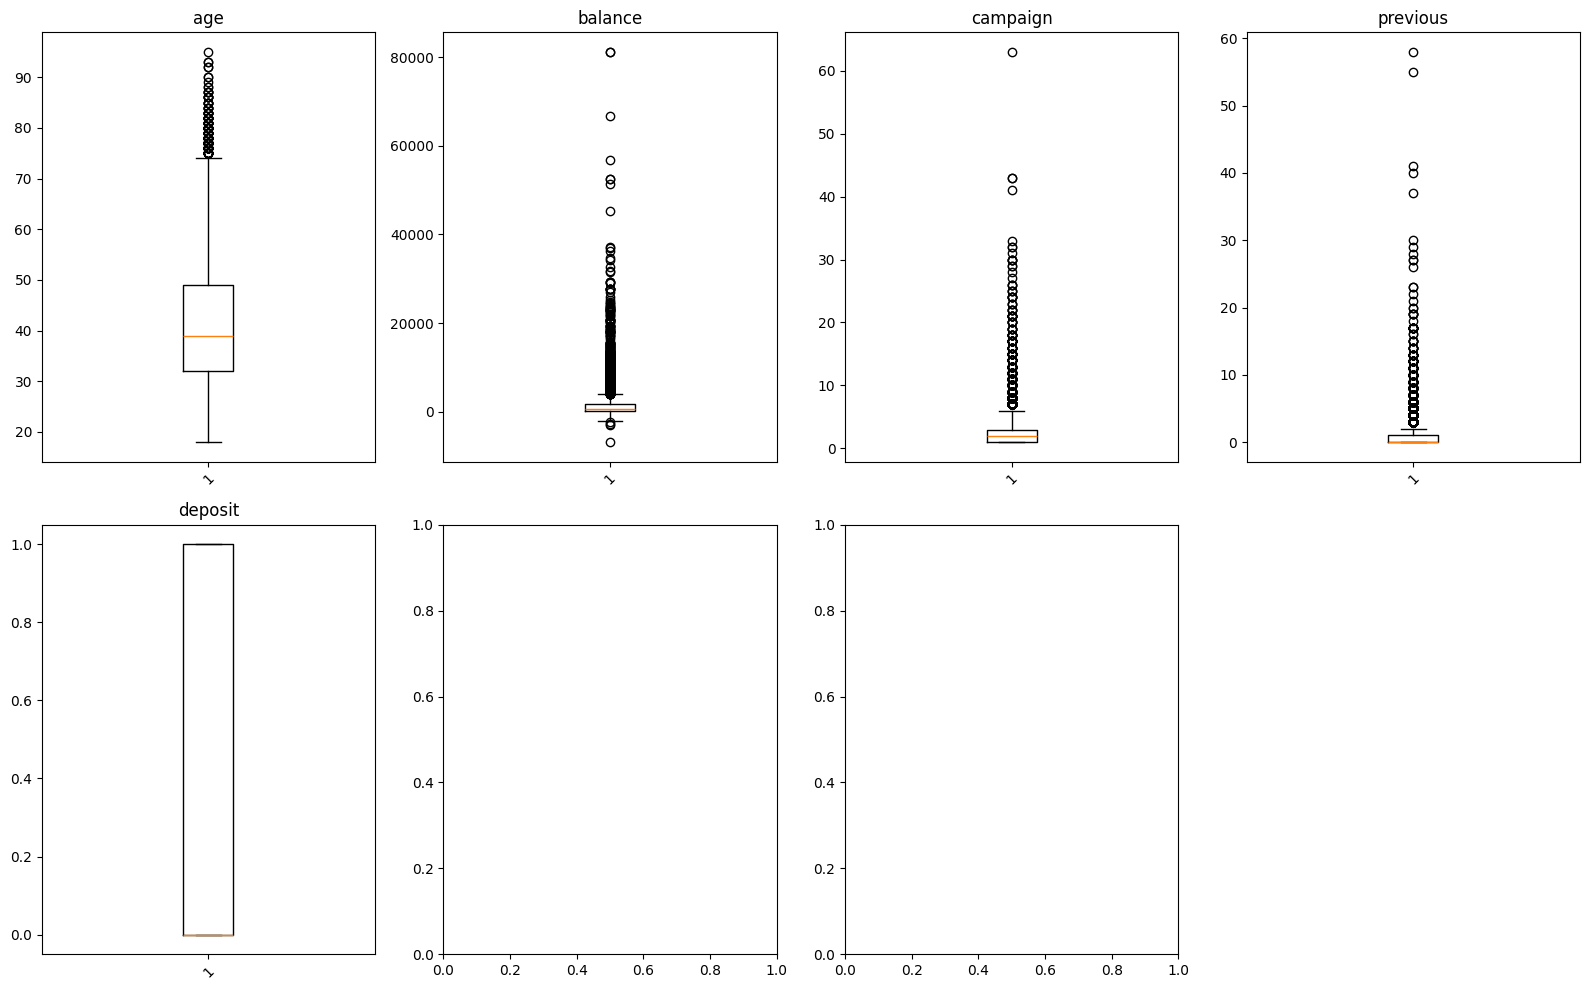

Boxplots de potenciales Outliers de columnas numericas


In [138]:
#Eliminacion de Outliers

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#Los valores de pdays son relevantes en las metricas
exclude_cols = ['pdays', 'duration', 'day']
numerical_cols =  [col for col in numerical_cols if col not in exclude_cols]
print("Numerical columns:", numerical_cols)

# descripcion
print("\
Descriptive statistics for numerical columns:")
print(df[numerical_cols].describe())

# Create boxplots
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplot
axes[7].remove()

plt.tight_layout()
plt.show()

print("Boxplots de potenciales Outliers de columnas numericas")



In [139]:
# Function de deteccion de outliers usando IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_info = {}
total_outliers = set()

print("Outlier IQR:")
print("=" * 50)

for col in numerical_cols:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    outlier_info[col] = {
        'outliers': outliers,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'count': len(outliers)
    }
    
    total_outliers.update(outliers.index.tolist())
    
    print(f"\
{col}:")
    print(f"  Lower bound: {lower_bound:.2f}")
    print(f"  Upper bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {len(outliers)}")
    print(f"  Percentage of outliers: {len(outliers)/len(df)*100:.2f}%")

print(f"\
Total unique rows with outliers: {len(total_outliers)}")
print(f"Percentage of total rows with outliers: {len(total_outliers)/len(df)*100:.2f}%")

Outlier IQR:
age:
  Lower bound: 6.50
  Upper bound: 74.50
  Number of outliers: 171
  Percentage of outliers: 1.53%
balance:
  Lower bound: -2257.00
  Upper bound: 4087.00
  Number of outliers: 1055
  Percentage of outliers: 9.45%
campaign:
  Lower bound: -2.00
  Upper bound: 6.00
  Number of outliers: 601
  Percentage of outliers: 5.38%
previous:
  Lower bound: -1.50
  Upper bound: 2.50
  Number of outliers: 1258
  Percentage of outliers: 11.27%
deposit:
  Lower bound: -1.50
  Upper bound: 2.50
  Number of outliers: 0
  Percentage of outliers: 0.00%
Total unique rows with outliers: 2819
Percentage of total rows with outliers: 25.26%


In [140]:
# Remove outliers from the dataset
print("Original dataset shape:", df.shape)

# Remove rows that contain outliers
df_clean = df.drop(index=list(total_outliers))

print("Dataset shape after removing outliers:", df_clean.shape)
print("Number of rows removed:", len(df) - len(df_clean))
print("Percentage of data retained:", len(df_clean)/len(df)*100, "%")

# Verify outlier removal by checking statistics
print("\
Comparison of statistics before and after outlier removal:")
print("=" * 60)

for col in numerical_cols:
    print(f"\
{col}:")
    print(f"  Original - Mean: {df[col].mean():.2f}, Std: {df[col].std():.2f}")
    print(f"  Clean    - Mean: {df_clean[col].mean():.2f}, Std: {df_clean[col].std():.2f}")
    print(f"  Change in Mean: {((df_clean[col].mean() - df[col].mean())/df[col].mean()*100):.2f}%")
    print(f"  Change in Std:  {((df_clean[col].std() - df[col].std())/df[col].std()*100):.2f}%")

Original dataset shape: (11162, 17)
Dataset shape after removing outliers: (8343, 17)
Number of rows removed: 2819
Percentage of data retained: 74.7446694140835 %
Comparison of statistics before and after outlier removal:
age:
  Original - Mean: 41.23, Std: 11.91
  Clean    - Mean: 40.23, Std: 10.87
  Change in Mean: -2.43%
  Change in Std:  -8.78%
balance:
  Original - Mean: 1528.54, Std: 3225.41
  Clean    - Mean: 789.88, Std: 993.00
  Change in Mean: -48.32%
  Change in Std:  -69.21%
campaign:
  Original - Mean: 2.51, Std: 2.72
  Clean    - Mean: 2.04, Std: 1.27
  Change in Mean: -18.77%
  Change in Std:  -53.31%
previous:
  Original - Mean: 0.83, Std: 2.29
  Clean    - Mean: 0.23, Std: 0.57
  Change in Mean: -71.78%
  Change in Std:  -75.23%
deposit:
  Original - Mean: 0.47, Std: 0.50
  Clean    - Mean: 0.44, Std: 0.50
  Change in Mean: -6.15%
  Change in Std:  -0.48%


In [141]:
#division de data para entranamiento y pruebas
# Codificar variables categóricas (One-hot encoding)
df_encoded = pd.get_dummies(df_clean, drop_first=True)

#Separar variables y etiquetas
X = df_encoded.drop(columns='deposit')
y = df_encoded['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
train_df = X_train.copy()
train_df['deposit'] = y_train

majority = train_df[train_df.deposit == 0]
minority = train_df[train_df.deposit == 1]

minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)
train_balanced = pd.concat([majority, minority_upsampled])
#Revision de Data valanciada
print(train_balanced['deposit'].value_counts())
###
train_balanced = pd.concat([majority, minority_upsampled])
train_balanced['deposit'] = train_balanced['deposit'].astype('category')
X_train_bal = train_balanced.drop(columns='deposit')
y_train_bal = train_balanced['deposit']


deposit
0    3243
1    3243
Name: count, dtype: int64


print("Valores nulos en X_train_bal:")
print(X_train_bal.isnull().sum())

# Verificar valores nulos en la variable objetivo
print("\nValores nulos en y_train_bal:")
print(y_train_bal.isnull().sum())

In [142]:
#Entrenar el modelo
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_bal, y_train_bal)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


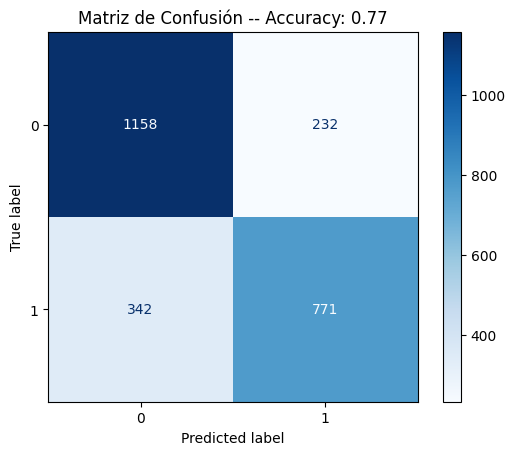

In [143]:
y_pred = model.predict(X_test)
#Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)
#Mostrar la matriz gráficamente
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusión -- Accuracy: {acc:.2f}")
plt.grid(False)
plt.show()
#Mostrar accuracy
acc = accuracy_score(y_test, y_pred)

In [144]:
# Definir KFold con K=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar usando accuracy como métrica
scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Mostrar resultados
print("Accuracy en cada fold:", scores)
print("Accuracy promedio:", np.mean(scores))

Accuracy en cada fold: [0.80347513 0.78849611 0.79868185 0.80995204 0.79916067]
Accuracy promedio: 0.7999531591024365


In [145]:
f1 = cross_val_score(model, X, y, cv=5, scoring='f1')
precision = cross_val_score(model, X, y, cv=5, scoring='precision')

print("F1 promedio:", f1.mean())
print("Precisión promedio:", precision.mean())

F1 promedio: 0.7126386549687489
Precisión promedio: 0.7492148894552294
